# Time Series Analysis

This is another tutorial from [Machine Learning Mastery](http://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/)

**The steps of this project that we will through are as follows.**

- Environment.
- Problem Description.
- Test Harness.
- Persistence.
- Data Analysis.
- ARIMA Models.
- Model Validation.

## Problem Description

The problem is to predict the number of monthly sales of champagne for the Perrin Freres label (named for a region in France).
The dataset provides the number of monthly sales of champagne from January 1964 to September 1972, or just under 10 years of data.
The values are a count of millions of sales and there are 105 observations.
The dataset is credited to Makridakis and Wheelwright, 1989.

The final year of data will be used to validate the final model.

In [5]:
from pandas import Series
series = Series.from_csv('data/champagne.csv', header=0)
series.head(5)

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Perrin Freres monthly champagne sales millions ?64-?72, dtype: int64

In [6]:
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 93, Validation 12


- dataset.csv: Observations from January 1964 to September 1971 (93 observations)
- validation.csv: Observations from October 1971 to September 1972 (12 observations)

## Persistence

The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance.

This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence.

This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

We can plug this directly into the test harness defined in the previous section.

The complete code listing is provided below.

In [7]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt


X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=4121.000, Expected=4647
>Predicted=4647.000, Expected=4753
>Predicted=4753.000, Expected=3965
>Predicted=3965.000, Expected=1723
>Predicted=1723.000, Expected=5048
>Predicted=5048.000, Expected=6922
>Predicted=6922.000, Expected=9858
>Predicted=9858.000, Expected=11331
>Predicted=11331.000, Expected=4016
>Predicted=4016.000, Expected=3957
>Predicted=3957.000, Expected=4510
>Predicted=4510.000, Expected=4276
>Predicted=4276.000, Expected=4968
>Predicted=4968.000, Expected=4677
>Predicted=4677.000, Expected=3523
>Predicted=3523.000, Expected=1821
>Predicted=1821.000, Expected=5222
>Predicted=5222.000, Expected=6872
>Predicted=6872.000, Expected=10803
>Predicted=10803.000, Expected=13916
>Predicted=13916.000, Expected=2639
>Predicted=2639.000, Expected=2899
>Predicted=2899.000, Expected=3370
>Predicted=3370.000, Expected=3740
>Predicted=3740.000, Expected=2927
>Predicted=2927.000, Expected=3986
>Predicted=3986.000, Expected=4217
>Predicted=4217.000, Expected=1738
>Predicted=173

The example ends by printing the RMSE for the model.

In this case, we can see that the persistence model achieved an RMSE of 3186.501. This means that on average, the model was wrong by about 3,186 million sales for each prediction made.

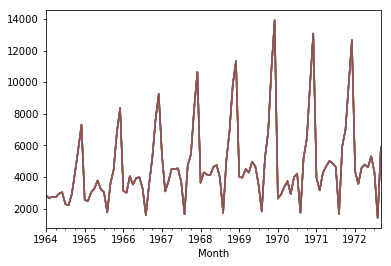

In [13]:
from matplotlib import pyplot
series.plot()
pyplot.show()

Some observations from the plot include:

There may be an increasing trend of sales over time.
There appears to be systematic seasonality to the sales for each year.
The seasonal signal appears to be growing over time, suggesting a multiplicative relationship (increasing change).
There do not appear to be any obvious outliers.
The seasonality suggests that the series is almost certainly non-stationary.

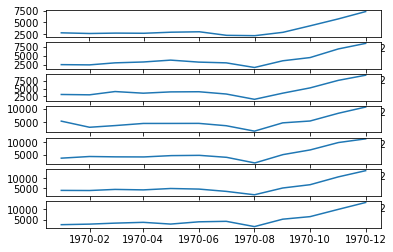

In [16]:
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot
groups = series['1964':'1970'].groupby(TimeGrouper('A'))
years = DataFrame()
pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
	pyplot.subplot((n_groups*100) + 10 + i)
	i += 1
	pyplot.plot(group)
pyplot.show()

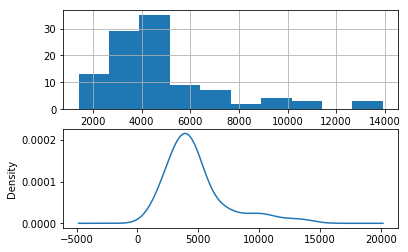

In [17]:
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

Some observations from the plots include:

The distribution is not Gaussian.
The shape has a long right tail and may suggest an exponential distribution


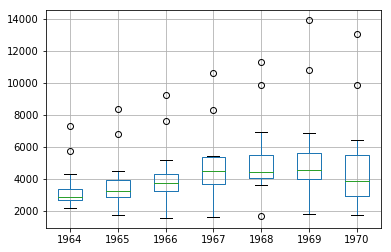

In [18]:
years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show()

The seasonality in the series is seemingly year-to-year. Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

/Users/xuemingli/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ADF Statistic: -7.626619
p-value: 0.000000
Critical Values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


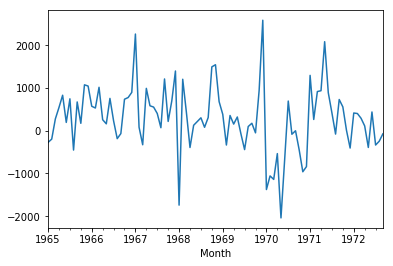

In [19]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

#series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot()
pyplot.show()

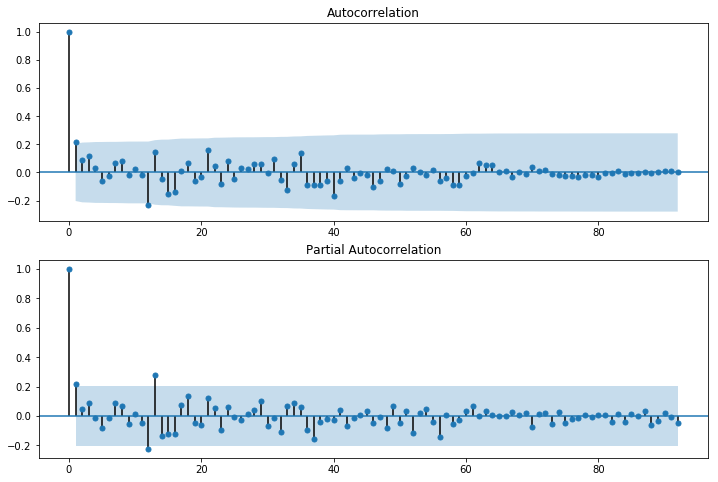

In [23]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('stationary.csv')
pyplot.figure(figsize = (12,8))
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()